**Import neccessary libraries**


In [42]:
#import needed libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import keras.applications
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import os

**To split data  into  train, test and validate folders split-folders library is used**

In [43]:
pip install split-folders

**Import data into folders**

In [44]:
import splitfolders
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
splitfolders.ratio(data_dir,output="Tr-Te-Val",ratio=(0.8,0.1,0.1))

Copying files: 3670 files [00:00, 3771.12 files/s]


**Preprocess image data and import data from the folders using image data generator**




In [45]:
train_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

val_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

test_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input
                 )

In [46]:
train_ds = train_gen.flow_from_directory("./Tr-Te-Val/train",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32
                                       )

val_ds = val_gen.flow_from_directory("./Tr-Te-Val/val",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32)

test_ds = test_gen.flow_from_directory("./Tr-Te-Val/test",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32,
                                      shuffle=False
                                      )

Found 2934 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 372 images belonging to 5 classes.


**Getting the name of classes for ease of use**

In [47]:
a = train_ds.class_indices
classes = list(a.keys())
print(classes)
b = test_ds.class_indices
classes = list(b.keys())
print(classes)
c = val_ds.class_indices
classes = list(c.keys())
print(classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Extracting one batch from datagen for visualization purposes**

In [48]:
#one batch
X,Y = next(train_ds)

In [49]:
#plot function
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i], clim=(0, 255))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

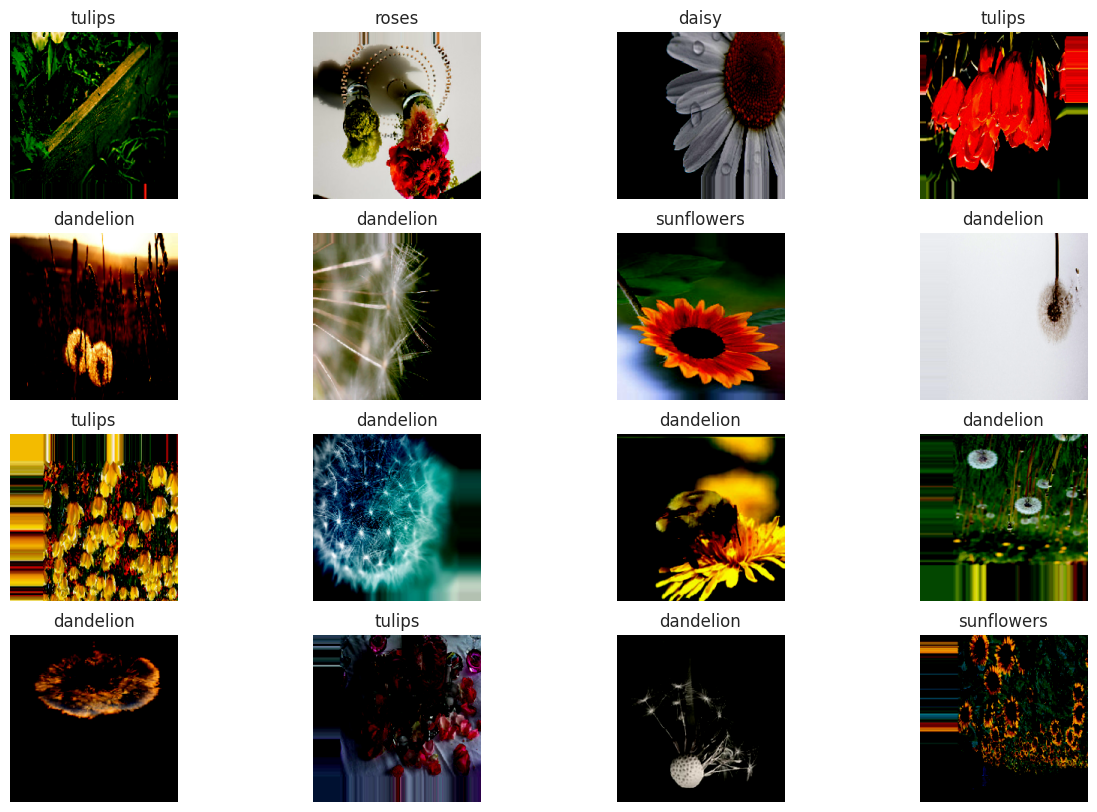

In [50]:
plot_images(X,Y)

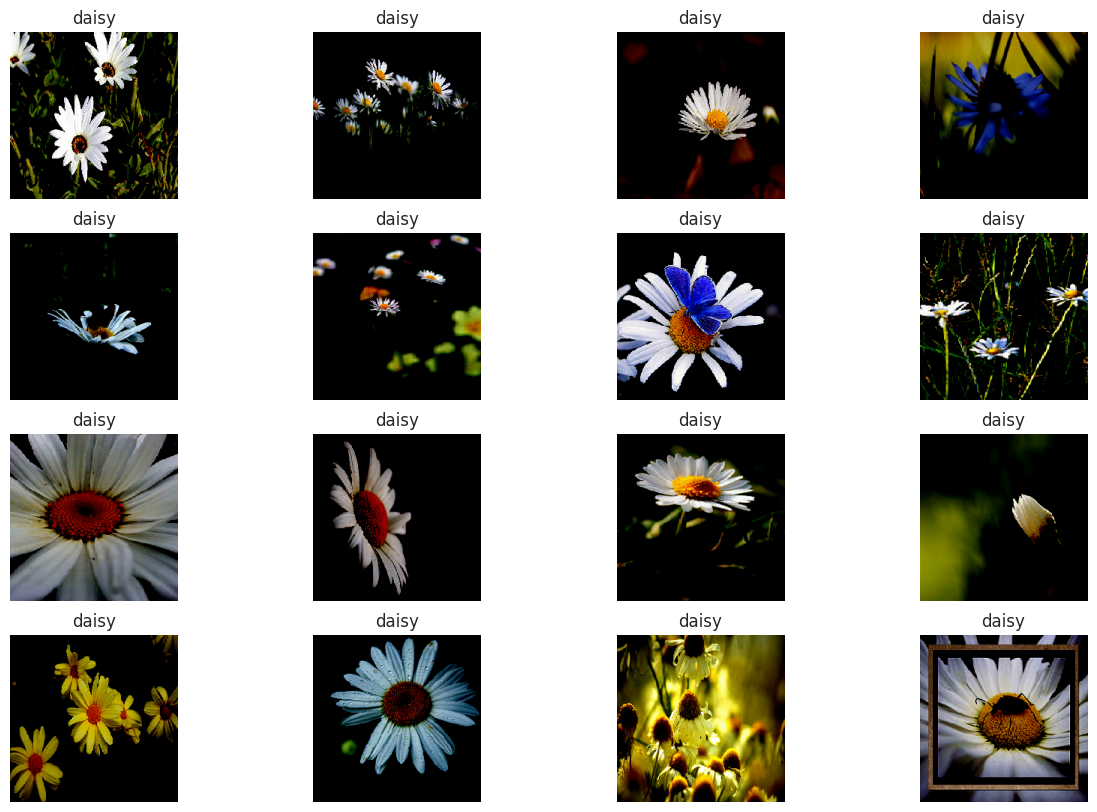

In [51]:
u,v=next(test_ds)
plot_images(u,v)

## **Using Transfer Learning to build the Flower Classifcation Model**

In [52]:
from tensorflow.keras.applications import ResNet152V2

In [69]:
#Define the base model
base_model = ResNet152V2(include_top=False,
                  input_shape=(224,224,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

In [54]:
#Add new layers
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(5,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [55]:
#model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [56]:
#compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Defining callbacks to get the best model possible**

In [57]:
#callbacks
model_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

**Training**

In [58]:
hist = model.fit(train_ds,epochs=18,validation_data=val_ds,callbacks=model_callbacks)

Epoch 1/18
92/92 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7747
Epoch 1: val_loss improved from inf to 0.49578, saving model to Model.h5
92/92 [==============================] - 88s 824ms/step - loss: 0.6015 - accuracy: 0.7747 - val_loss: 0.4958 - val_accuracy: 0.8434
Epoch 2/18
92/92 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8599
Epoch 2: val_loss improved from 0.49578 to 0.40801, saving model to Model.h5
92/92 [==============================] - 64s 701ms/step - loss: 0.3921 - accuracy: 0.8599 - val_loss: 0.4080 - val_accuracy: 0.8599
Epoch 3/18
92/92 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8804
Epoch 3: val_loss improved from 0.40801 to 0.35401, saving model to Model.h5
92/92 [==============================] - 64s 699ms/step - loss: 0.3248 - accuracy: 0.8804 - val_loss: 0.3540 - val_accuracy: 0.8709
Epoch 4/18
92/92 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8964
E

**Getting the saved model**

In [59]:
model = load_model("./Model.h5")

**Evaluate on test data**

In [60]:
#test
model.evaluate(test_ds)

12/12 [==============================] - 6s 241ms/step - loss: 0.3247 - accuracy: 0.8790


[0.32468345761299133, 0.8790322542190552]

**Graphs to show loss and accuracy along the training**

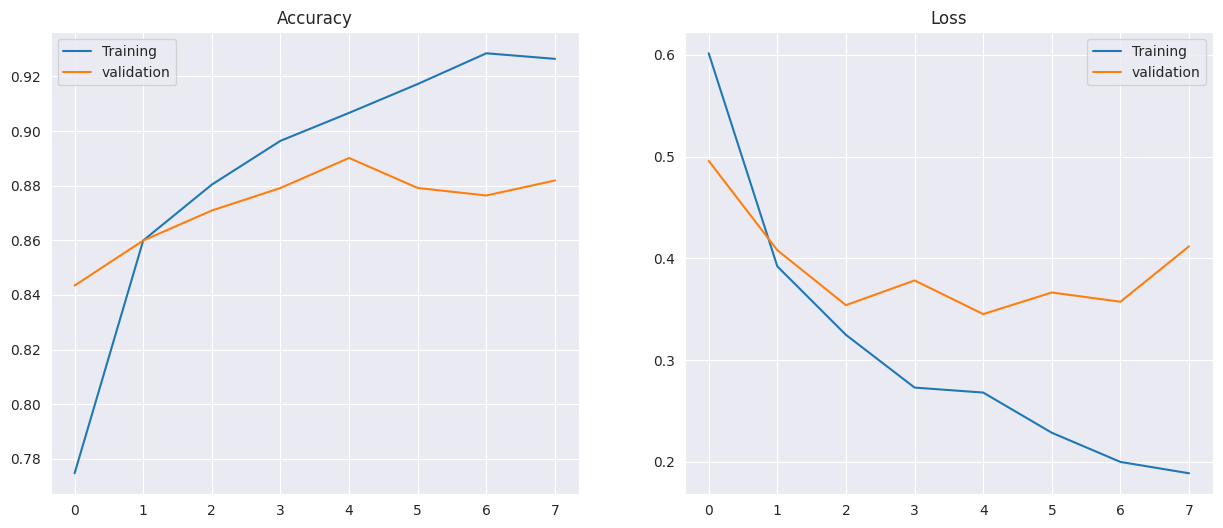

In [61]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Making Predictions and Verifying**

In [62]:
preds = model.predict(test_ds,verbose=1)

12/12 [==============================] - 5s 244ms/step


In [63]:
pred = [np.argmax(i) for i in preds]
pred[:5]

[0, 0, 0, 0, 0]

In [64]:
actual = test_ds.classes

**Classification Report**

In [65]:
print(classification_report(pred,actual))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        66
           1       0.89      0.94      0.92        86
           2       0.88      0.78      0.83        73
           3       0.92      0.88      0.90        74
           4       0.79      0.88      0.83        73

    accuracy                           0.88       372
   macro avg       0.88      0.88      0.88       372
weighted avg       0.88      0.88      0.88       372



**Confusion Matrix**

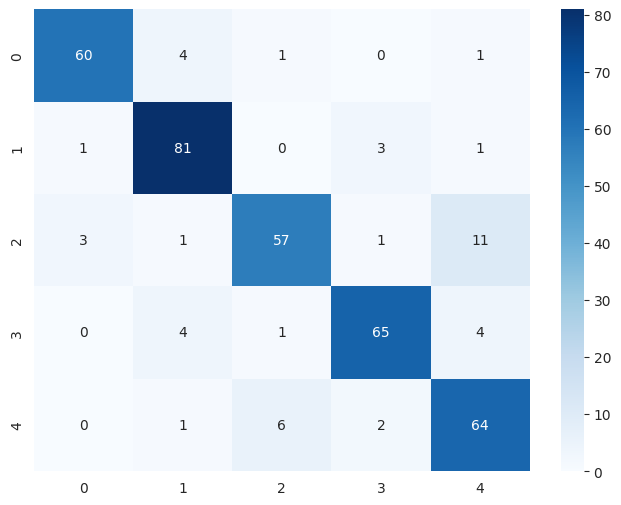

In [66]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred,actual),annot = True, fmt = 'd', cmap = 'Blues');